<a href="https://colab.research.google.com/github/tgrappoport/2dmat/blob/master/3_QHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let us now explore graphene under an external magnetic field to obtain the Landau levels and quantum Hall effect.

**Be aware that calculations involving the conductivity tensor in real space can take some time.**

We begin with the usual import of libraries and installation of pybinding and kite and

In [ ]:
%%capture --no-display

!pip install h5py==3.11.0
!pip install -i https://test.pypi.org/simple/ pybinding quantum-kite==0.0.4

In [ ]:
import numpy as np
from math import sqrt, pi
import pybinding as pb
import kite
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pybinding.repository import graphene

# seaborn setting
sns.set(style="ticks")
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})


To use pybinding for this type of calculation, we can set a powerfull tool that is the modifier of the hamiltonian. It allows us to modify either the onsite energy or the hoppings. For the magnetic field, using Pierls´s substitution $$t_{ij}\rightarrow t_{ij}e^{i\frac{2\pi}{\phi_0}\int_{ij}\vec{A}_{ij}\cdot d\vec{l}},$$
we need to modify the hopping. For a Landau gauge, the modifier can be written as

In [ ]:
def constant_magnetic_field(B):
    @pb.hopping_energy_modifier
    def function(energy, x1, y1, x2, y2):
        # the midpoint between two sites
        y = 0.5 * (y1 + y2)
        # scale from nanometers to meters
        y *= 1e-9

        # vector potential along the x-axis
        A_x = B * y

        # integral of (A * dl) from position 1 to position 2
        peierls = A_x * (x1 - x2)
        # scale from nanometers to meters (because of x1 and x2)
        peierls *= 1e-9
        phi0=2.0678346*1e-15
        # the Peierls substitution
        return energy * np.exp(1j * 2*pi/phi0 * peierls)
    return function





When calling the model, we now include the modifier and we define a finite system so that we do not need to worry about boundary conditions. Still, to have defined Landau levels for a system this size, we need to use artificially large magnetic fields, as otherwise the cyclotron orbit radius will be larger than the system length


In [ ]:
model = pb.Model(
    graphene.monolayer(),
    pb.rectangle(30),
    constant_magnetic_field(B=100)  # Tesla
)

We use the pybinding version of kpm to find the local density of states at the center of the sample (that should have the structure of the global density of states for large systems without disorder). The figure below shows the different Landau levels with high density of states, separated by insulating regions. **Be aware that the conductivity calculations present in pybinding produce spurious results and we will stick to quantum-kite for this type of calculation.**

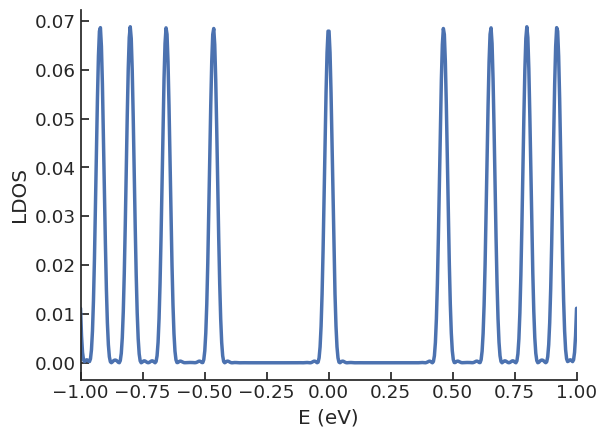

In [ ]:
kpm = pb.kpm(model)

ldos = kpm.calc_ldos(energy=np.linspace(-1, 1, 500), broadening=0.015, position=[0, 0])
ldos.plot()
plt.show()

Now we can calculate the density of state and Hall conductivity for a periodic system. Because the Hall conductivity is a more time and memory demanding calculation, as it needs more moments and random vectors to converge, we will use a a relativelly small system and very large magnetic fields so that we can run it in google colab.

We first define the lattice and use graphene from pybinding:

In [ ]:
lattice = graphene.monolayer()

 The number of decomposition parts `[nx,ny]` in each direction of matrix.
This divides the lattice into various sections, each of which is calculated in parallel

In [ ]:
nx = ny = 2

The number of unit cells in each direction (we keep a relativelly small system because of the constrains of online notebooks. You can increase this number if running it on your own computer)

In [ ]:
lx = ly = 128

Boundary Mode

In [ ]:
mode = "periodic"

 specify precision of the exported hopping and onsite data, 0 - float, 1 - double, and 2 - long double.
 For complex hoppings as in the case of Pierls´ substitution, one needs to set `is_complex=True,`

In [ ]:
configuration = kite.Configuration(
        divisions=[nx, ny],
        length=[lx, ly],
        boundaries=[mode, mode],
        is_complex=True,
        precision=1
)


Finally we specify our calculations. The number of moments in our expansion is crucial in the case of the QHE as few moments do not allow to define the Landau levels. Still, for such a small system, the only the Landau levels close to $E=0$ are well defined.

In [ ]:
calculation = kite.Calculation(configuration)
calculation.dos(
        num_points=4000,
        num_moments=256,
        num_random=2,
        num_disorder=1
)

calculation.conductivity_dc(
    num_points=5000,
    num_moments=256,
    num_random=15,
    direction='xy',
    temperature=0.05
)

We can now add some modifications. First, let us add some disorder. Disorder cannot modify the height of the QHE plateaus, as they have topological origin. Still, it helps the convergence of the method for small systems and can be useful for preliminary tests with kite.

In [ ]:
disorder = kite.Disorder(lattice)
disorder.add_disorder('A', 'Uniform', +0.0, 0.4)
disorder.add_disorder('B', 'Uniform', +0.0, 0.4)

Finally, we can add the modifier of the magnetic field. Because the system is periodic, only a finite set of magnetic fields are allowed, matching the magnetic supercell. Refer to quantum-kite documentation for that. Kite automatically finds the allowed magnetic field which is close to the value provided by the user.

In [ ]:
mod = kite.Modification(magnetic_field=2400)


Finally, the h5 output file used by kitex and kite-tools and its configuration:

In [ ]:
output_file = "graphene_qhe.h5"
kite.config_system(lattice, configuration, calculation, modification=mod, filename=output_file,disorder=disorder)


##############################################################################
#                        KITE | Release  1.1                                 #
#                        Kite home: quantum-kite.com                         #
#                                                                            #
#                        Copyright 2022, KITE                                #
##############################################################################

##############################################################################

SCALING:


Automatic scaling is being done. If unexpected results are produced, consider 
selecting the bounds manually. 
Estimate of the spectrum bounds with a safety factor is: 
(-8.52, 8.48 eV)


##############################################################################

BOUNDARY CONDITIONS:


Boundary conditions along the lattice vectors are set to:
 
a1: Periodic     a2: Periodic 


##################################################

We are ready to perform the calculation

In [ ]:
kite.execute.kitex(output_file);

<HDF5 dataset "IS_COMPLEX": shape (), type "<u4">


and use the postprocessing tool with some extra options as the window of Fermi energies for the conductivity calculation (-F) and and the number of energy points in the Kubo formula integration (-E). For more details, refere to [kite-tools API](https://quantum-kite.com/api/kite-tools/#advanced-usage)

In [ ]:
kite.execute.kitetools("graphene_qhe.h5 --CondDC -F -3 3 1000 -E 5000 -T 0.07");


Finally, we are ready to see the density of states with its Landau levels that have some broadening due to disorder.

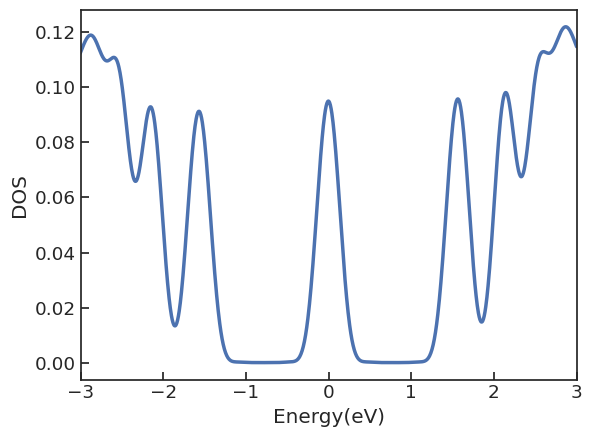

In [ ]:
dos=np.loadtxt("dos.dat",dtype=float)
plt.plot(dos[:,0],dos[:,1])
plt.xlabel("Energy(eV)")
plt.ylabel("DOS")
plt.xlim(-3,3)
#plt.ylim(0,0.08)
plt.show()
#cond=np.loadtxt("condDC.dat",dtype=float)
#plt.plot(cond[:,0],cond[:,1])
#plt.xlabel("Energy(eV)")
#plt.ylabel("$\sigma_{xy}(e^2/h)$")
#plt.xlim(-1.2,1.2)
#plt.show()

and the transverse conductivity with its quantized plateaus

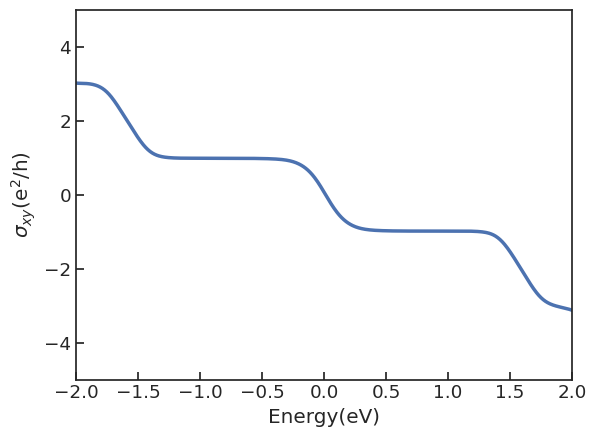

In [ ]:
cond=np.loadtxt("condDC.dat",dtype=float)
plt.plot(cond[:,0],-cond[:,1])
plt.xlabel("Energy(eV)")
plt.ylabel("$\sigma_{xy}$(e$^2$/h)")
plt.xlim(-2,2)
plt.ylim(-5,5)
plt.show()